In [3]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install requests pandas numpy matplotlib ta

Note: you may need to restart the kernel to use updated packages.



=== Fetching data for bitcoin ===
CoinGecko Data for bitcoin: 2024-07-18 00:00:00 to 2024-10-15 16:06:20
Combined Data for bitcoin: 2024-07-18 00:00:00 to 2024-10-15 16:06:20
Fetched data for bitcoin: 91 records.

=== Fetching data for ethereum ===
CoinGecko Data for ethereum: 2024-07-18 00:00:00 to 2024-10-15 16:23:38
Combined Data for ethereum: 2024-07-18 00:00:00 to 2024-10-15 16:23:38
Fetched data for ethereum: 91 records.

=== Fetching data for litecoin ===
CoinGecko Data for litecoin: 2024-07-18 00:00:00 to 2024-10-15 16:31:14
Combined Data for litecoin: 2024-07-18 00:00:00 to 2024-10-15 16:31:14
Fetched data for litecoin: 91 records.


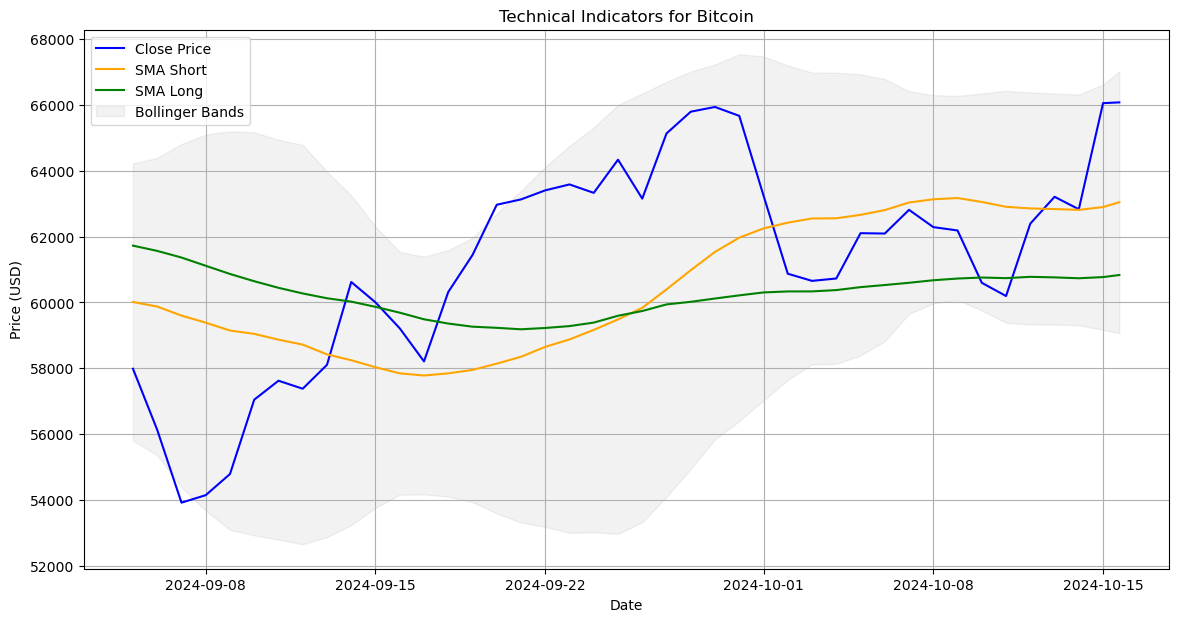

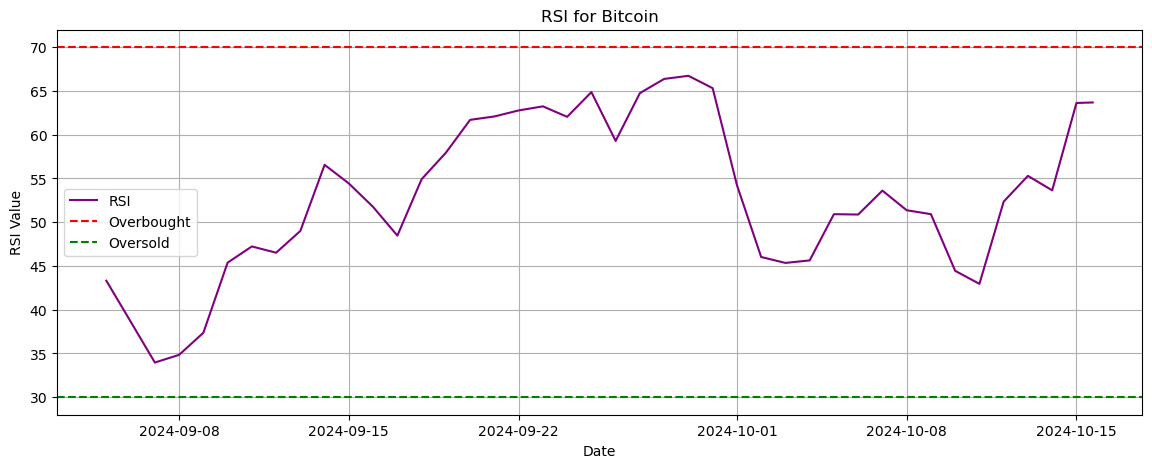

Data for bitcoin saved to bitcoin_technical_rates.csv


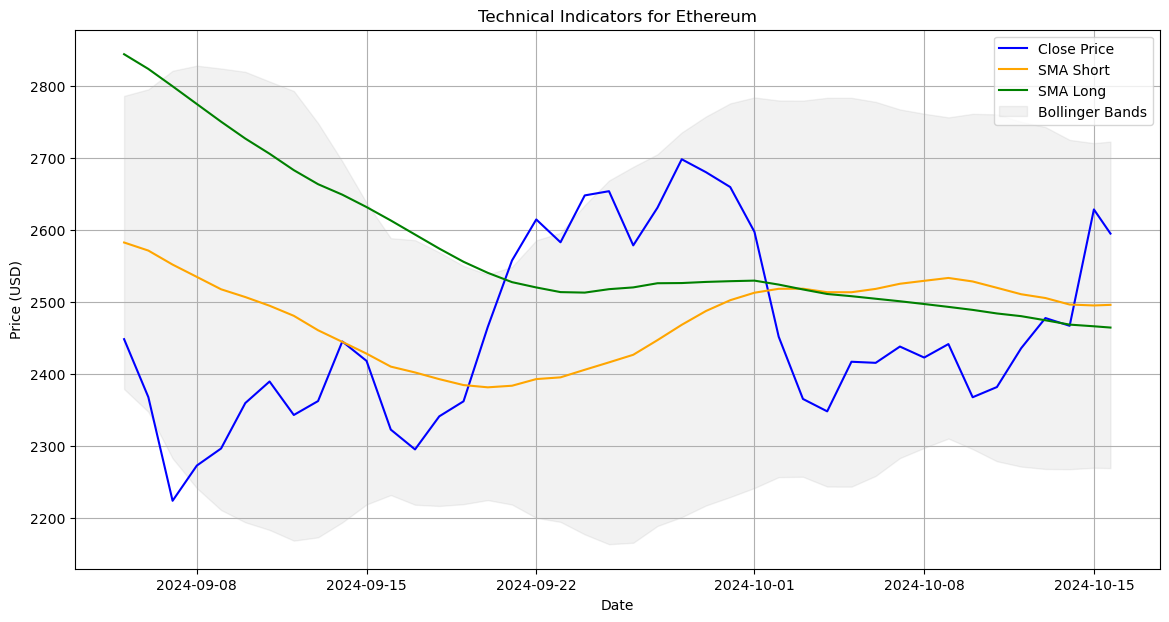

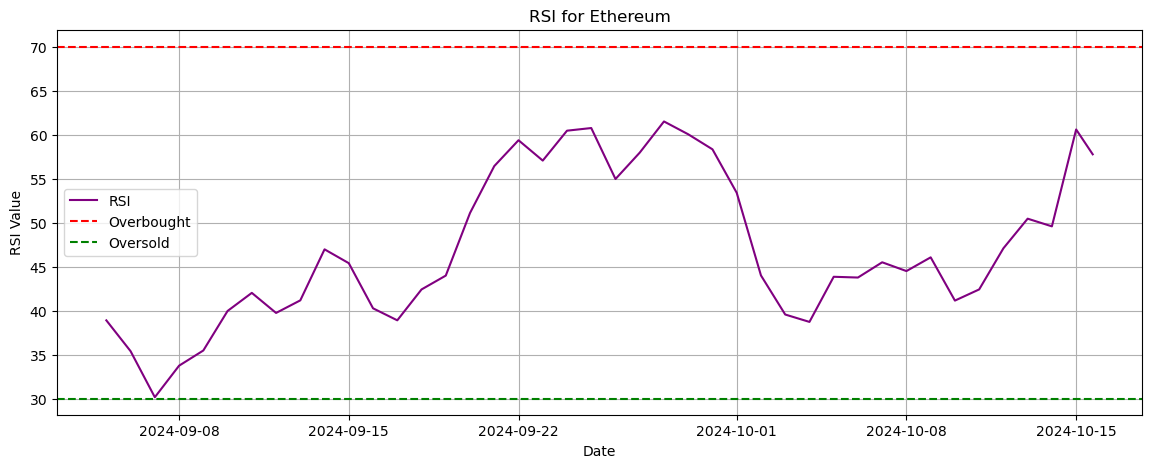

Data for ethereum saved to ethereum_technical_rates.csv


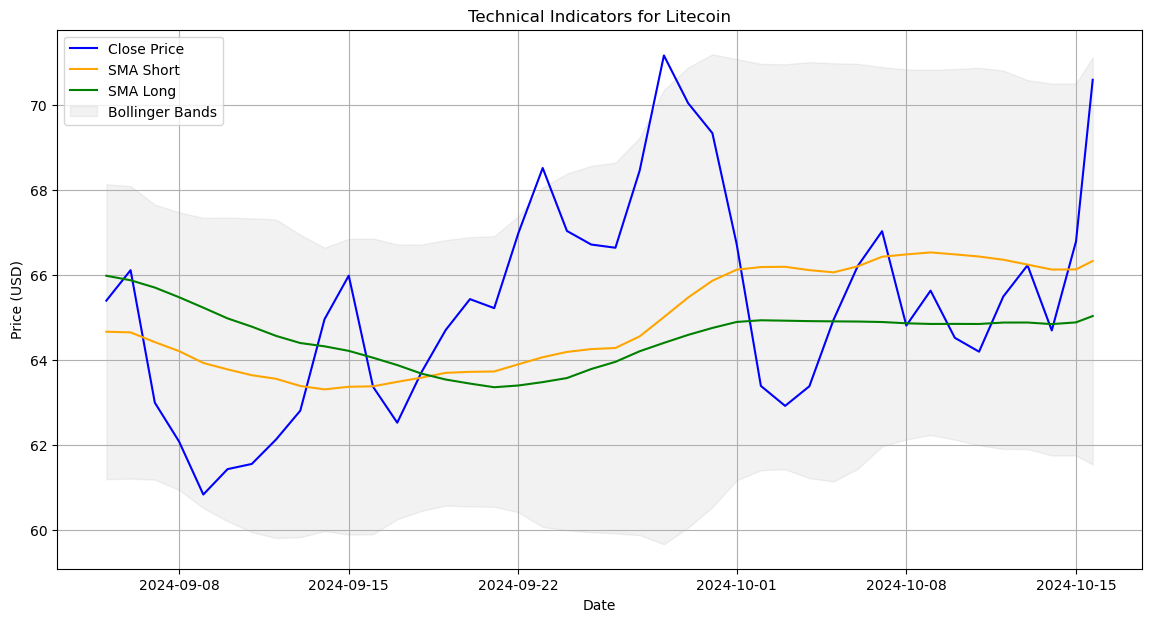

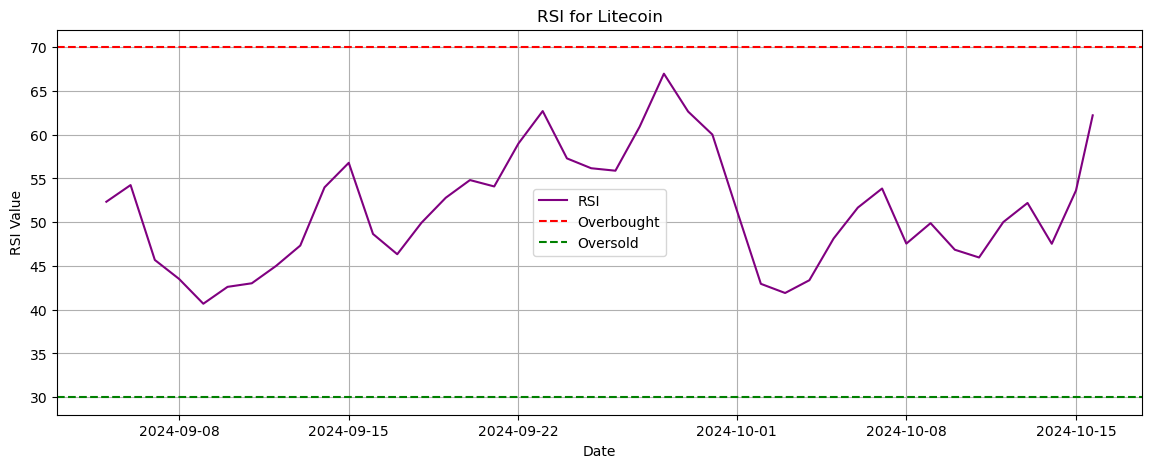

Data for litecoin saved to litecoin_technical_rates.csv
Exchange Rates:
{'bitcoin': {'usd': 66486, 'eur': 61028, 'jpy': 9927605, 'gbp': 50839, 'aud': 99097}, 'ethereum': {'usd': 2590.36, 'eur': 2377.7, 'jpy': 386789, 'gbp': 1980.72, 'aud': 3860.93}, 'litecoin': {'usd': 69.77, 'eur': 64.04, 'jpy': 10418.15, 'gbp': 53.35, 'aud': 103.99}}
                    Cryptocurrency         Close     SMA_Short      SMA_Long  \
Date                                                                           
2024-09-05 00:00:00        bitcoin  57987.846014  60014.115634  61725.133687   
2024-09-06 00:00:00        bitcoin  56132.404732  59876.639581  61565.055505   
2024-09-07 00:00:00        bitcoin  53923.356111  59601.267805  61364.331247   
2024-09-08 00:00:00        bitcoin  54150.938359  59386.900036  61113.559038   
2024-09-09 00:00:00        bitcoin  54792.407558  59147.773123  60865.285895   
...                            ...           ...           ...           ...   
2024-10-12 00:00:00   

In [35]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta import trend, momentum, volatility

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Fiat currencies for exchange rates
FIAT_CURRENCIES = ['usd', 'eur', 'jpy', 'gbp', 'aud']  # Use lowercase for CoinGecko

# Timeframe for historical data (Last 90 days)
DAYS = '90'  # API may expect string

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()

        # Verification
        print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")

        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

def fetch_exchange_rates():
    """Fetches exchange rates for cryptocurrencies against FIAT currencies."""
    url = f'https://api.coingecko.com/api/v3/simple/price'

    # Create a comma-separated string of cryptocurrency IDs
    crypto_ids = ','.join(CRYPTOCURRENCIES)
    params = {
        'ids': crypto_ids,
        'vs_currencies': ','.join(FIAT_CURRENCIES)
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        print("Exchange Rates:")
        print(data)
        return data
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error: {e}")
        return None

# Placeholder function for mapping cryptocurrency symbols
def crypto_symbol_mapping(crypto):
    """Maps CoinGecko cryptocurrency IDs to another source's symbols (placeholder)."""
    mapping = {
        'bitcoin': 'BTC',
        'ethereum': 'ETH',
        'litecoin': 'LTC'
    }
    return mapping.get(crypto)

# Placeholder functions for other data sources
def fetch_cryptocompare_data(symbol):
    """Placeholder for fetching data from CryptoCompare."""
    return pd.DataFrame()  # Implement actual API call

# Other placeholder functions (omitted for brevity)

def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame using the `ta` library."""
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float
    df.dropna(subset=['Close'], inplace=True)  # Drop NaN values if necessary
    df['SMA_Short'] = trend.sma_indicator(close=df['Close'], window=SMA_SHORT)
    df['SMA_Long'] = trend.sma_indicator(close=df['Close'], window=SMA_LONG)
    df['RSI'] = momentum.rsi(close=df['Close'], window=RSI_PERIOD)

    # Corrected BollingerBands usage
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()

    return df

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df['Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df

def plot_technical_indicators(df, crypto):
    """Plots the technical indicators for the given cryptocurrency."""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(df.index, df['SMA_Long'], label='SMA Long', color='green')
    plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='grey', alpha=0.1, label='Bollinger Bands')
    plt.title(f"Technical Indicators for {crypto.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

def fetch_all_crypto_data():
    """Fetches historical data from multiple sources for all cryptocurrencies."""
    crypto_data = {}
    for crypto in CRYPTOCURRENCIES:
        print(f"\n=== Fetching data for {crypto} ===")
        data_frames = []

        # 1. CoinGecko
        cg_data = fetch_coin_gecko_data(crypto)
        if not cg_data.empty:
            data_frames.append(cg_data)

        # 2. CryptoCompare
        cc_symbol = crypto_symbol_mapping(crypto)  # Ensure this function is defined
        if cc_symbol:
            cc_data = fetch_cryptocompare_data(cc_symbol)
            if not cc_data.empty:
                data_frames.append(cc_data)

        # Additional API data fetching...
        
        if not data_frames:
            print(f"No data fetched for {crypto}. Skipping.")
            continue
        
        # Combine all data frames on Date index
        combined = pd.concat(data_frames, axis=1)

        # Calculate mean Close price across available sources
        combined['Close'] = combined.filter(like='Close').mean(axis=1)
        combined = combined[['Close']].sort_index()

        # Verification of date range
        print(f"Combined Data for {crypto}: {combined.index.min()} to {combined.index.max()}")

        # Assign Data ID
        combined['Data ID'] = combined.index.to_series().apply(lambda x: get_hash(x.strftime('%Y-%m-%d')))

        # Store in crypto_data dictionary
        crypto_data[crypto] = combined
        print(f"Fetched data for {crypto}: {combined.shape[0]} records.")

    return crypto_data

def plot_rsi(df, crypto):
    """Plots the RSI for the given cryptocurrency."""
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought')
    plt.axhline(30, linestyle='--', color='green', label='Oversold')
    plt.title(f"RSI for {crypto.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

def display_data_as_table(data_dict):
    """Displays the dataset as a table."""
    # Concatenate all DataFrames into a single DataFrame for display
    combined_df = pd.concat(data_dict.values(), keys=data_dict.keys())
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Cryptocurrency'})
    print(combined_df)

def fetch_all_crypto_data():
    """Fetches historical data from multiple sources for all cryptocurrencies."""
    crypto_data = {}
    for crypto in CRYPTOCURRENCIES:
        print(f"\n=== Fetching data for {crypto} ===")
        data_frames = []

        # 1. CoinGecko
        cg_data = fetch_coin_gecko_data(crypto)
        if not cg_data.empty:
            data_frames.append(cg_data)

        # 2. CryptoCompare
        cc_symbol = crypto_symbol_mapping(crypto)  # Ensure this function is defined
        if cc_symbol:
            cc_data = fetch_cryptocompare_data(cc_symbol)
            if not cc_data.empty:
                data_frames.append(cc_data)

        # Additional API data fetching...
        
        if not data_frames:
            print(f"No data fetched for {crypto}. Skipping.")
            continue
        
        # Combine all data frames on Date index
        combined = pd.concat(data_frames, axis=1)

        # Calculate mean Close price across available sources
        combined['Close'] = combined.filter(like='Close').mean(axis=1)
        combined = combined[['Close']].sort_index()

        # Verification of date range
        print(f"Combined Data for {crypto}: {combined.index.min()} to {combined.index.max()}")

        # Removing the Data ID assignment
        # combined['Data ID'] = combined.index.to_series().apply(lambda x: get_hash(x.strftime('%Y-%m-%d')))

        # Store in crypto_data dictionary
        crypto_data[crypto] = combined
        print(f"Fetched data for {crypto}: {combined.shape[0]} records.")

    return crypto_data

def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame using the `ta` library and drops rows with NaN values."""
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float
    df.dropna(subset=['Close'], inplace=True)  # Drop NaN values in 'Close' column

    # Calculate technical indicators
    df['SMA_Short'] = trend.sma_indicator(close=df['Close'], window=SMA_SHORT)
    df['SMA_Long'] = trend.sma_indicator(close=df['Close'], window=SMA_LONG)
    df['RSI'] = momentum.rsi(close=df['Close'], window=RSI_PERIOD)
    
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()

    # Drop rows where any of the indicator columns have NaN values
    df.dropna(subset=['SMA_Short', 'SMA_Long', 'RSI', 'Bollinger_High', 'Bollinger_Low'], inplace=True)

    return df
    
# =========================
# Main Execution Flow
# =========================
if __name__ == "__main__":
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis and plotting
    for crypto, df in all_crypto_data.items():
        analyzed_df = perform_technical_analysis(df)
        trend_identified_df = identify_trends(analyzed_df)

        # Plotting the technical indicators and RSI
        plot_technical_indicators(trend_identified_df, crypto)
        plot_rsi(trend_identified_df, crypto)

        # Save to CSV for each cryptocurrency
        csv_filename = f"{crypto}_technical_rates.csv"
        trend_identified_df.to_csv(csv_filename)
        print(f"Data for {crypto} saved to {csv_filename}")

    # Fetch exchange rates once for all cryptocurrencies
    fetch_exchange_rates()

    # Display the fetched data as a table
    display_data_as_table(all_crypto_data)


=== Fetching data for bitcoin ===
Combined Data for bitcoin: 2024-07-18 00:00:00 to 2024-10-15 16:06:20
Fetched data for bitcoin: 91 records.

=== Fetching data for ethereum ===
Combined Data for ethereum: 2024-07-18 00:00:00 to 2024-10-15 16:23:38
Fetched data for ethereum: 91 records.

=== Fetching data for litecoin ===
Combined Data for litecoin: 2024-07-18 00:00:00 to 2024-10-15 16:31:14
Fetched data for litecoin: 91 records.


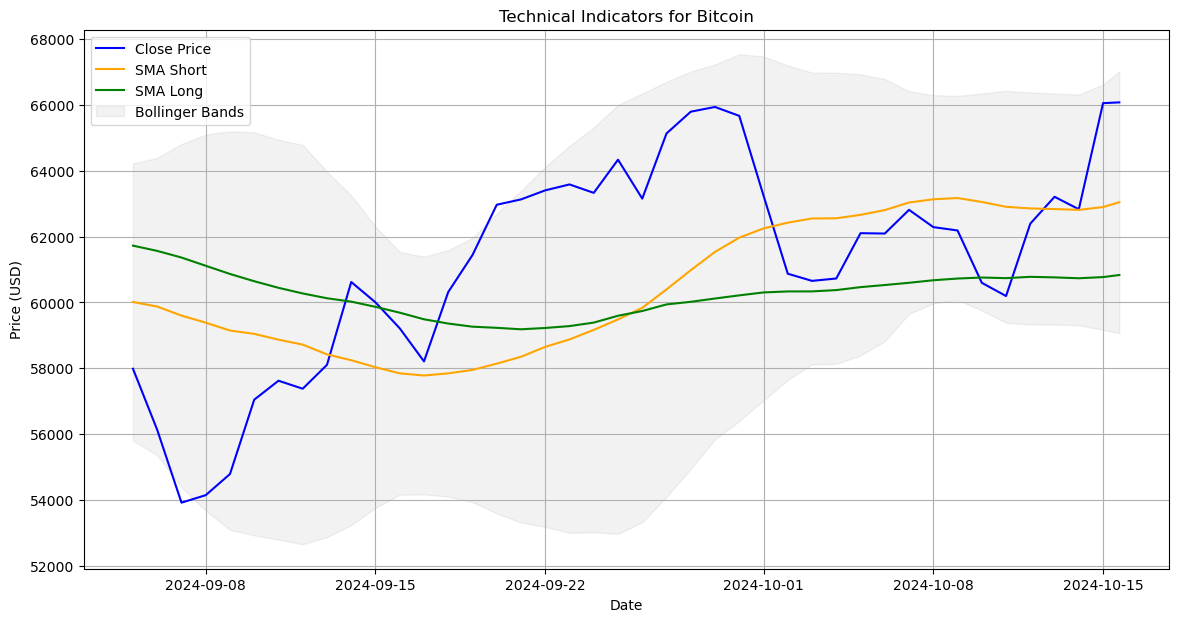

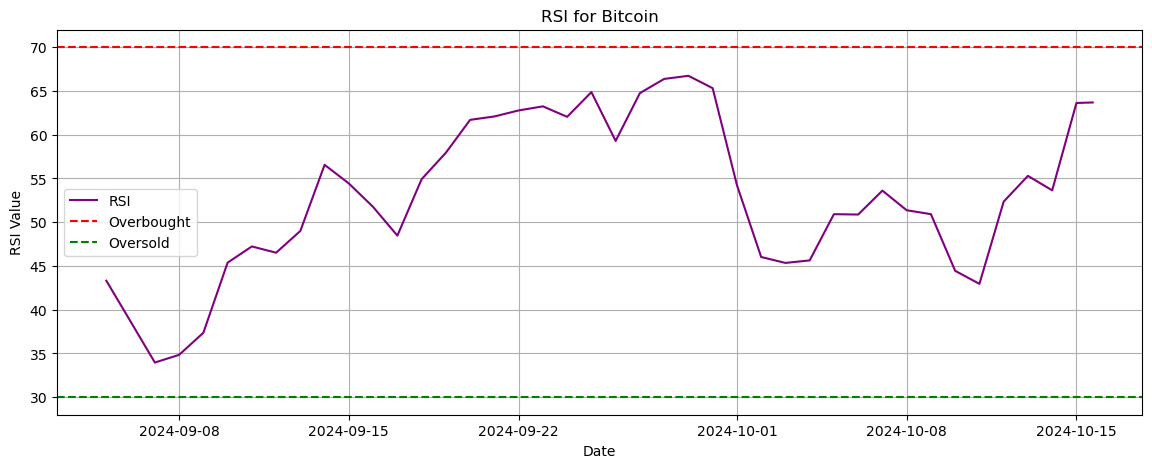

Data for bitcoin saved to bitcoin_forcast_rates.csv


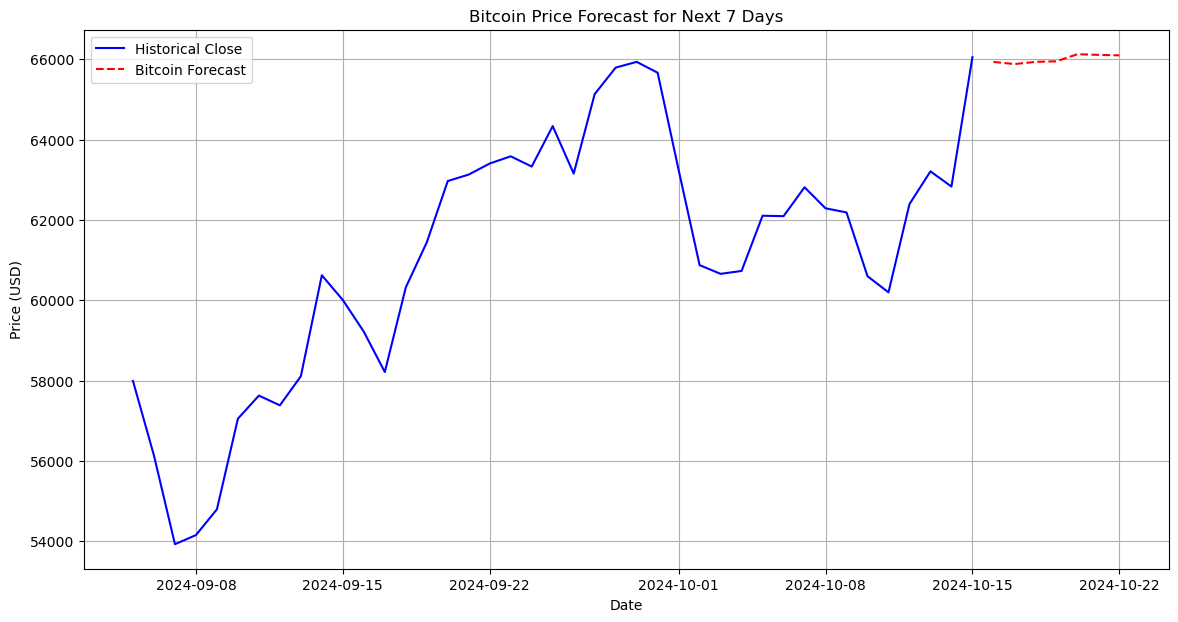

RMSE for Bitcoin: 1315.1556765699038
RMSE for Bitcoin: 1315.1556765699038


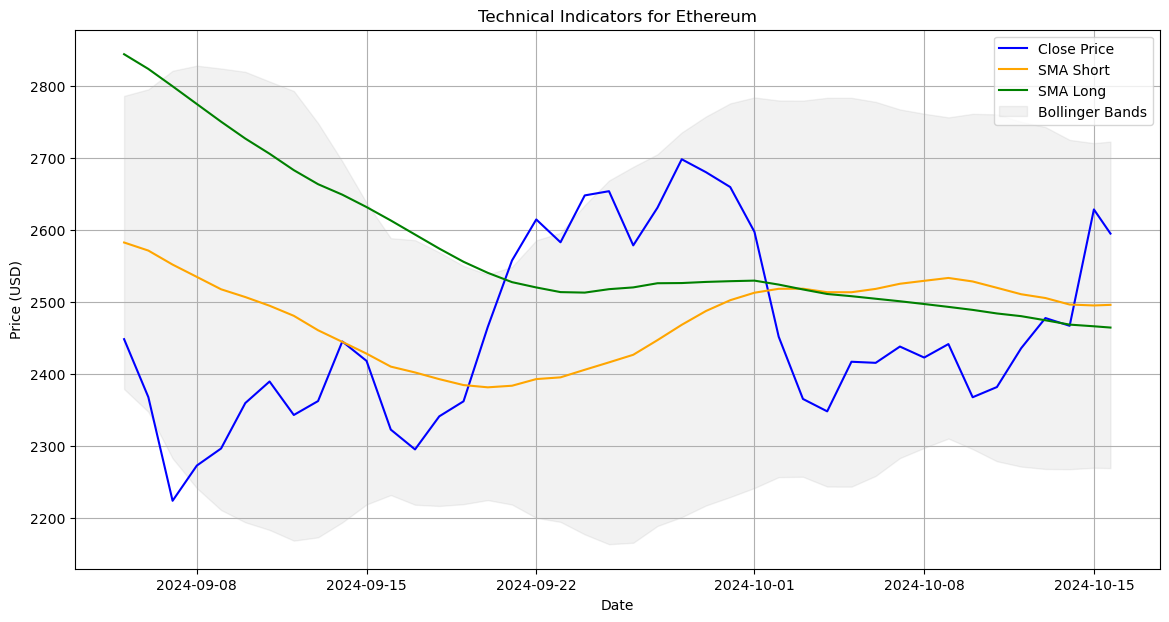

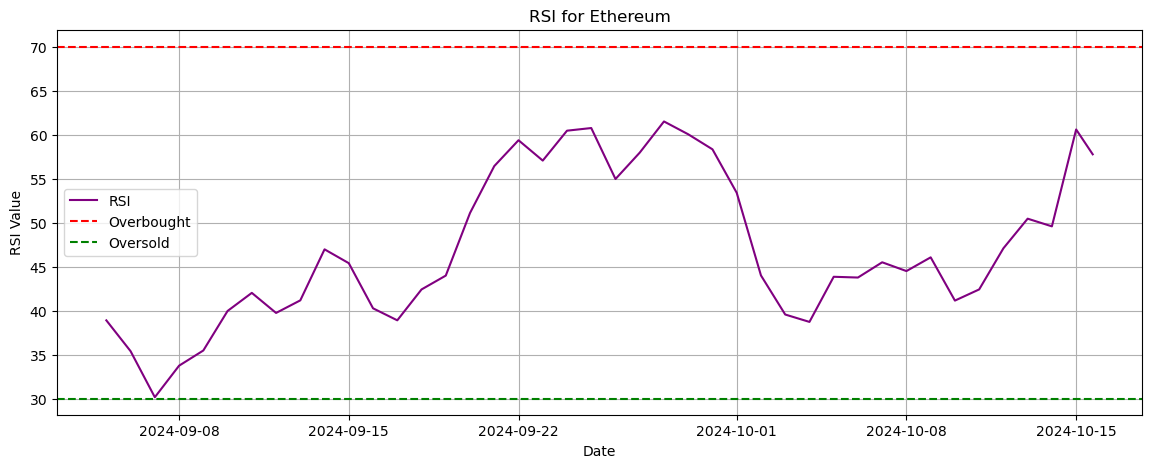

Data for ethereum saved to ethereum_forcast_rates.csv


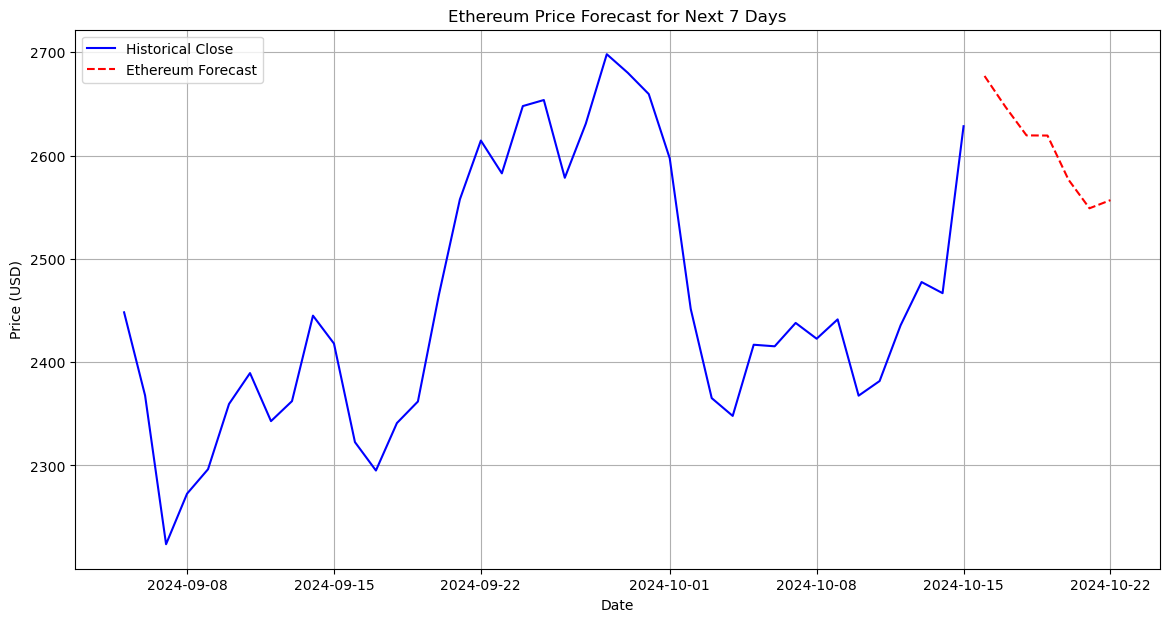

RMSE for Ethereum: 57.29782662791299
RMSE for Ethereum: 57.29782662791299


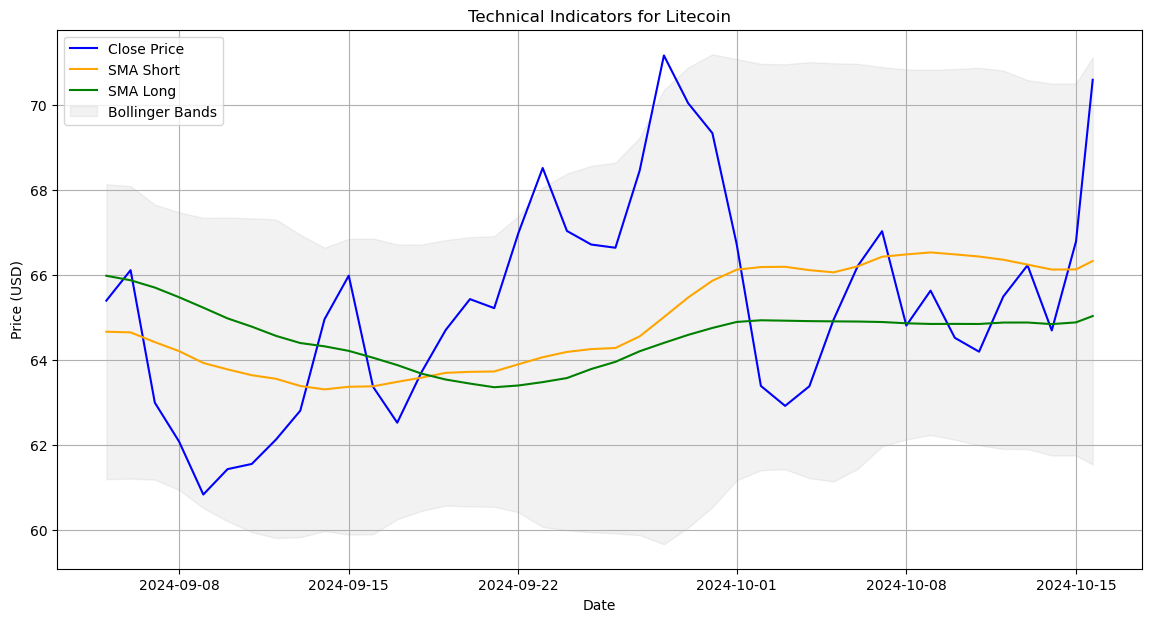

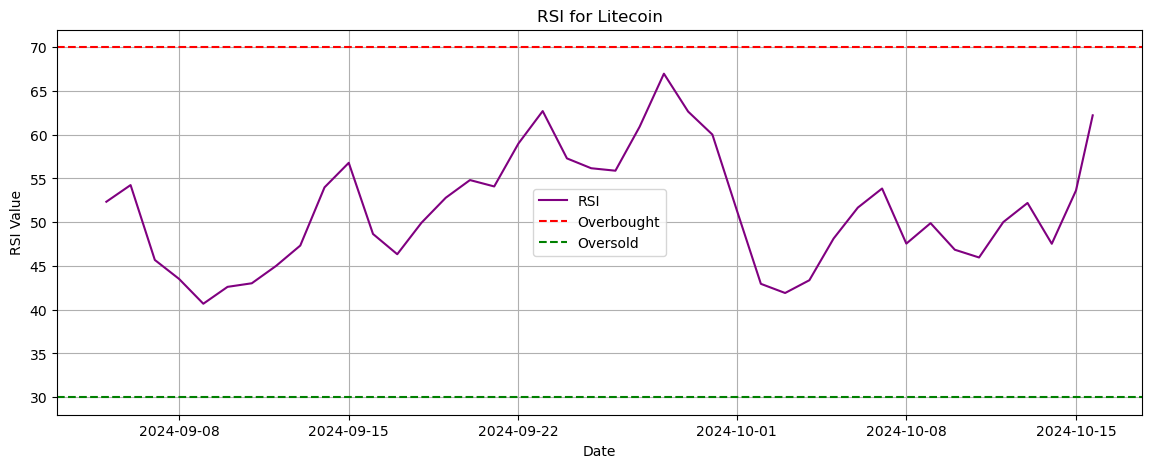

Data for litecoin saved to litecoin_forcast_rates.csv


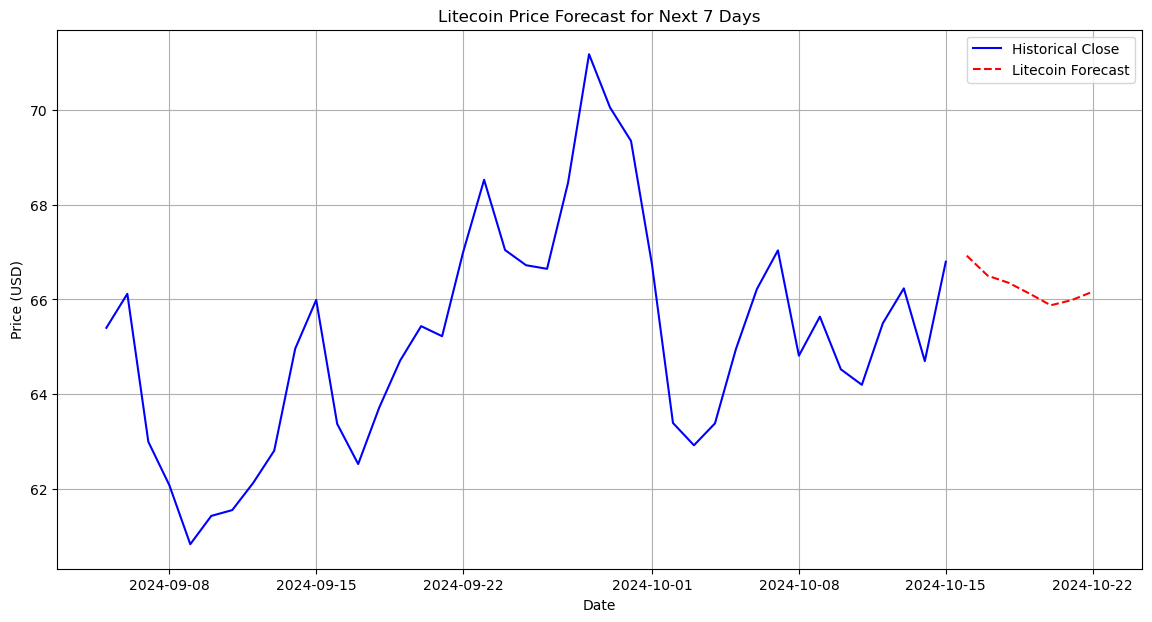

RMSE for Litecoin: 1.3774846424805347
RMSE for Litecoin: 1.3774846424805347
Exchange Rates:
{'bitcoin': {'usd': 66486, 'eur': 61028, 'jpy': 9927605, 'gbp': 50839, 'aud': 99097}, 'ethereum': {'usd': 2590.36, 'eur': 2377.7, 'jpy': 386789, 'gbp': 1980.72, 'aud': 3860.93}, 'litecoin': {'usd': 69.77, 'eur': 64.04, 'jpy': 10418.15, 'gbp': 53.35, 'aud': 103.99}}
                    Cryptocurrency         Close     SMA_Short      SMA_Long  \
Date                                                                           
2024-09-05 00:00:00        bitcoin  57987.846014  60014.115634  61725.133687   
2024-09-06 00:00:00        bitcoin  56132.404732  59876.639581  61565.055505   
2024-09-07 00:00:00        bitcoin  53923.356111  59601.267805  61364.331247   
2024-09-08 00:00:00        bitcoin  54150.938359  59386.900036  61113.559038   
2024-09-09 00:00:00        bitcoin  54792.407558  59147.773123  60865.285895   
...                            ...           ...           ...           ...   
20

In [33]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta import trend, momentum, volatility
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# =========================
# Configuration and Settings
# =========================
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']
FIAT_CURRENCIES = ['usd', 'eur', 'jpy', 'gbp', 'aud']
DAYS = '90'
SMA_SHORT = 20
SMA_LONG = 50
RSI_PERIOD = 14
PREDICTION_DAYS = 7  # Number of days to forecast

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()

        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

# =========================
# Quantitative Statistics and Prediction
# =========================
def generate_forecast(df, crypto, days=PREDICTION_DAYS):
    """Generates a forecast using ARIMA model."""
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float

    # Infer or set the frequency for the date index
    if df.index.freq is None:
        df = df.asfreq('D')  # Set to daily frequency ('D')
    
    model = ARIMA(df['Close'], order=(5, 1, 0))  # ARIMA(p=5, d=1, q=0)
    model_fit = model.fit()

    # Forecast future prices
    forecast = model_fit.forecast(steps=days)
    
    # Set forecast dates with proper frequency
    forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')

    # Plot forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Historical Close', color='blue')
    plt.plot(forecast_dates, forecast, label=f'{crypto.capitalize()} Forecast', color='red', linestyle='--')
    plt.title(f"{crypto.capitalize()} Price Forecast for Next {days} Days")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate and print the RMSE (Root Mean Squared Error)
    history_len = len(df['Close'])
    prediction_len = min(history_len, 30)  # Take the last 30 data points for RMSE calculation
    past_values = df['Close'].values[-prediction_len:]
    predictions = model_fit.predict(start=history_len - prediction_len, end=history_len - 1)

    rmse = np.sqrt(mean_squared_error(past_values, predictions))
    print(f"RMSE for {crypto.capitalize()}: {rmse}")

    # Calculate and print the RMSE (Root Mean Squared Error)
    history_len = len(df['Close'])
    prediction_len = min(history_len, 30)  # Take the last 30 data points for RMSE calculation
    past_values = df['Close'].values[-prediction_len:]
    predictions = model_fit.predict(start=history_len - prediction_len, end=history_len - 1)

    rmse = np.sqrt(mean_squared_error(past_values, predictions))
    print(f"RMSE for {crypto.capitalize()}: {rmse}")

# =========================
# Main Execution Flow
# =========================
if __name__ == "__main__":
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis, prediction, and plotting
    for crypto, df in all_crypto_data.items():
        if df.empty:
            continue  # Skip if no data
        analyzed_df = perform_technical_analysis(df)
        trend_identified_df = identify_trends(analyzed_df)

        # Plotting the technical indicators and RSI
        plot_technical_indicators(trend_identified_df, crypto)
        plot_rsi(trend_identified_df, crypto)

        # Save to CSV for each cryptocurrency
        csv_filename = f"{crypto}_forcast_rates.csv"
        trend_identified_df.to_csv(csv_filename)
        print(f"Data for {crypto} saved to {csv_filename}")

        # Forecast the cryptocurrency price for the next PREDICTION_DAYS
        generate_forecast(df, crypto, days=PREDICTION_DAYS)

    # Fetch exchange rates once for all cryptocurrencies
    fetch_exchange_rates()

    # Display the fetched data as a table
    display_data_as_table(all_crypto_data)